#**Análise do perfil de crédito**

##**1 - Entendimento do negócio**


O problema apresentado traz o desafio de prever a **capacidade de um cliente para reembolsar um empréstimo**. Neste cenário, a empresa PoD Bank se esforça para expandir o acesso ao crédito para uma clientela com **histórico de crédito insuficiente ou inexistente**. Utilizando uma variedade de fontes de dados, incluindo registros de transações bancárias, histórico de pagamentos, e informações socioeconômicas, o objetivo é construir um **modelo preditivo que possa avaliar a probabilidade de inadimplência de um cliente**.

Este problema é crucial porque ajuda a empresa a **minimizar os riscos de crédito** ao mesmo tempo em que possibilita o acesso a **empréstimos para indivíduos que tradicionalmente não teriam essa oportunidade**. Portanto, trata-se de um equilíbrio entre responsabilidade financeira e inclusão social

- **Público**: clientes que irão solicitar empréstimo na Pod Bank. Em nossa tabela, esse público é representado por um número do emprestimo - cada linha um emprestimo.

### **Para esse estudo será realizado uma EDA para identificar padrões no perfil das pessoas Inadimplentes e Adimplentes**
- Definição de uma pessoa inadimplente: Uma pessoa inadimplente é aquela que não paga suas dívidas no prazo acordado.

## **2 - Entendimento dos Dados**
Para a resolução dessa análise será usado uma base de dados de pessoas que solicitaram crédito ao banco disponibilizada pela PoD Academy (dados fícticios para fins didáticos)
Temos como Target a coluna TARGET, onde 1 significa inadimplente e 0 adimplente, o dicionário de dados estará em anexo junto do notebook

##**3 - Importações e Pré-Processamentos**
Nesse caso não realizei a substituição dos valores nulos para valores simbólicos a fim de entender se a falta de preenchimento dos valores seria um indicativo de inadimplência

###Funções gráficas

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Ajuste da exibição de números para evitar notação científica
    pd.options.display.float_format = '{:.6f}'.format

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'cardinalidade': dataframe.nunique(),
    })

    # Adiciona a coluna de valores mínimos para as colunas numéricas
    min_values = dataframe.select_dtypes(include='number').min()
    metadata['valor_minimo'] = metadata['nome_variavel'].map(min_values)

    # Ordena por tipo de dado
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

def boxplots_var_num(dataframe):
    """
    Plota boxplots para todas as variáveis numéricas do dataframe fornecido em um painel com 3 gráficos por linha.

    :param dataframe: DataFrame para o qual os boxplots serão gerados.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows * 4))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        sns.boxplot(data=dataframe[column], ax=axes[i//3, i%3], color="skyblue")
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('')

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Boxplots", fontsize=20, fontweight='bold', y=1.00)


def histograms_var_num(dataframe):
    """
    Plota histogramas corrigidos com a curva KDE (Kernel Density Estimation) para todas as variáveis numéricas
    do dataframe fornecido em um painel com 3 gráficos por linha.

    :param dataframe: DataFrame para o qual os histogramas serão gerados.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows * 4))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota histogramas com KDE para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        sns.histplot(data=dataframe[column], ax=axes[i//3, i%3], color="skyblue", bins=30, kde=True)
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('Frequência')
        axes[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Histograma com KDE", fontsize=20, fontweight='bold', y=1.00)

def plot_categorical_frequency_pt(df, corte_cardinalidade=30, graficos_por_linha=2):
    """
    Plota a frequência de categorias para variáveis categóricas em um DataFrame.

    Parâmetros:
    - df: DataFrame para plotagem.
    - corte_cardinalidade: Cardinalidade máxima para uma coluna ser considerada (padrão é 30).
    - graficos_por_linha: Quantidade de gráficos por linha (padrão é 3).

    Retorna:
    - Exibe os gráficos de barras.
    """

    # Gera metadados para o DataFrame
    metadados = []
    for coluna in df.columns:
        metadados.append({
            'Variável': coluna,
            'Tipo': df[coluna].dtype,
            'Cardinalidade': df[coluna].nunique()
        })

    df_metadados = pd.DataFrame(metadados)

    # Filtra colunas com cardinalidade maior que o corte e tipos não numéricos
    variaveis_categoricas = df_metadados[(df_metadados['Cardinalidade'] <= corte_cardinalidade) & (df_metadados['Tipo'] == 'object')]

    # Calcula o número de linhas e colunas para os subplots
    n_linhas = -(-len(variaveis_categoricas) // graficos_por_linha)  # Ceiling division
    n_colunas = min(len(variaveis_categoricas), graficos_por_linha)

    # Plota as variáveis categóricas
    fig, axs = plt.subplots(nrows=n_linhas, ncols=n_colunas, figsize=(12, 4 * n_linhas))

    for i, (idx, linha) in enumerate(variaveis_categoricas.iterrows()):
        var = linha['Variável']
        ax = axs[i // graficos_por_linha, i % graficos_por_linha]
        df[var].value_counts().sort_index().plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'Frequência em {var}')
        ax.set_ylabel('Frequência')
        ax.set_xlabel(var)

    # Remove os eixos vazios, se houver
    for j in range(i + 1, n_linhas * n_colunas):
        axs[j // graficos_por_linha, j % graficos_por_linha].axis('off')

    plt.tight_layout()
    plt.show()

def kdeplots_var_num_target(dataframe, target_column):
    """
    Plota gráficos kdeplot (Kernel Density Estimation) para todas as variáveis numéricas do DataFrame,
    discriminando as curvas de acordo com o valor da coluna target.

    :param dataframe: DataFrame contendo as variáveis numéricas e a coluna target.
    :param target_column: Nome da coluna target.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows * 4))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota kdeplots para cada coluna numérica, discriminando as curvas pelo valor da coluna target
    for i, column in enumerate(numeric_columns):
        sns.kdeplot(data=dataframe[dataframe[target_column] == 1][column], ax=axes[i//3, i%3], color="blue", label="1", fill=True, warn_singular=False)
        sns.kdeplot(data=dataframe[dataframe[target_column] == 0][column], ax=axes[i//3, i%3], color="red", label="0", fill=True, warn_singular=False)
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('Densidade')
        axes[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)
        if i == 0:
            axes[i//3, i%3].legend(title=target_column)

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Gráfico KDE por Target", fontsize=20, fontweight='bold', y=1.00)

###**3.1 - Carregamento dos dados e analise dos metadados**

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [101]:
df = pd.read_csv('application_train.csv')
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      247330       0         Cash loans           F            N   
1      425716       1         Cash loans           F            Y   
2      331625       0         Cash loans           M            Y   
3      455397       0    Revolving loans           F            N   
4      449114       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  AMT_ANNUITY  \
0               N             0     157500.000000 706410.000000 67072.500000   
1               Y             1     121500.000000 545040.000000 25407.000000   
2               Y             1     225000.000000 942300.000000 27679.500000   
3               Y             2     144000.000000 180000.000000  9000.000000   
4               Y             0     112500.000000 729792.000000 37390.500000   

   AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0    679500.000000   Unaccompanied  Commercial associate   
1    450000.000000   Unaccompanied               Working   
2    675000.000000   Unaccompanied               Working   
3    180000.000000   Unaccompanied  Commercial associate   
4    630000.000000   Unaccompanied             Pensioner   

             NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
0               Higher education            Married    House / apartment   
1  Secondary / secondary special            Married    House / apartment   
2  Secondary / secondary special            Married  Municipal apartment   
3  Secondary / secondary special          Separated    House / apartment   
4  Secondary / secondary special     Civil marriage    House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.032561      -14653          -2062       -8599.000000   
1                    0.007114      -13995          -2246        -348.000000   
2                    0.022625      -21687          -1335       -6306.000000   
3                    0.006629      -13071          -2292        -742.000000   
4                    0.046220      -19666         365243        -169.000000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2087          NaN           1               1                0   
1             -172    12.000000           1               1                1   
2            -4026     1.000000           1               1                0   
3            -1201          NaN           1               1                1   
4            -3112          NaN           1               0                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL        OCCUPATION_TYPE  \
0                 1           1           0  Private service staff   
1                 1           1           0            Secretaries   
2                 1           0           0               Laborers   
3                 1           1           0          Cooking staff   
4                 1           0           0                    NaN   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0         2.000000                     1                            1   
1         3.000000                     2                            2   
2         3.000000                     2                            2   
3         3.000000                     2                            2   
4         2.000000                     1                            1   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       13   
1                     MONDAY                       10   
2                   THURSDAY                       10   
3                     MONDAY                        8   
4                     FRIDAY                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1       

In [102]:
metadado = generate_metadata(df)
metadado

nome_variavel     tipo  qt_nulos  percent_nulos  \
0                      SK_ID_CURR    int64         0       0.000000   
1         HOUR_APPR_PROCESS_START    int64         0       0.000000   
2      REG_REGION_NOT_LIVE_REGION    int64         0       0.000000   
3      REG_REGION_NOT_WORK_REGION    int64         0       0.000000   
4     LIVE_REGION_NOT_WORK_REGION    int64         0       0.000000   
5          REG_CITY_NOT_LIVE_CITY    int64         0       0.000000   
6          REG_CITY_NOT_WORK_CITY    int64         0       0.000000   
7         LIVE_CITY_NOT_WORK_CITY    int64         0       0.000000   
8                 FLAG_DOCUMENT_3    int64         0       0.000000   
9                FLAG_DOCUMENT_21    int64         0       0.000000   
10               FLAG_DOCUMENT_20    int64         0       0.000000   
11               FLAG_DOCUMENT_19    int64         0       0.000000   
12               FLAG_DOCUMENT_18    int64         0       0.000000   
13    REGION_RATING_CLIENT_W_CITY    int64         0       0.000000   
14               FLAG_DOCUMENT_17    int64         0       0.000000   
15               FLAG_DOCUMENT_15    int64         0       0.000000   
16               FLAG_DOCUMENT_14    int64         0       0.000000   
17               FLAG_DOCUMENT_13    int64         0       0.000000   
18               FLAG_DOCUMENT_12    int64         0       0.000000   
19               FLAG_DOCUMENT_11    int64         0       0.000000   
20               FLAG_DOCUMENT_10    int64         0       0.000000   
21                FLAG_DOCUMENT_9    int64         0       0.000000   
22                FLAG_DOCUMENT_8    int64         0       0.000000   
23                FLAG_DOCUMENT_7    int64         0       0.000000   
24                FLAG_DOCUMENT_6    int64         0       0.000000   
25                FLAG_DOCUMENT_5    int64         0       0.000000   
26                FLAG_DOCUMENT_4    int64         0       0.000000   
27               FLAG_DOCUMENT_16    int64         0       0.000000   
28           REGION_RATING_CLIENT    int64         0       0.000000   
29                FLAG_DOCUMENT_2    int64         0       0.000000   
30                     FLAG_EMAIL    int64         0       0.000000   
31                         TARGET    int64         0       0.000000   
32                     FLAG_PHONE    int64         0       0.000000   
33               FLAG_CONT_MOBILE    int64         0       0.000000   
34                FLAG_WORK_PHONE    int64         0       0.000000   
35                 FLAG_EMP_PHONE    int64         0       0.000000   
36                     FLAG_MOBIL    int64         0       0.000000   
37                     DAYS_BIRTH    int64         0       0.000000   
38                DAYS_ID_PUBLISH    int64         0       0.000000   
39                  DAYS_EMPLOYED    int64         0       0.000000   
40                   CNT_CHILDREN    int64         0       0.000000   
41                         var_32  float64         0       0.000000   
42     AMT_REQ_CREDIT_BUREAU_HOUR  float64     29150      13.540000   
43      AMT_REQ_CREDIT_BUREAU_DAY  float64     29150      13.540000   
44     AMT_REQ_CREDIT_BUREAU_YEAR  float64     29150      13.540000   
45      AMT_REQ_CREDIT_BUREAU_MON  float64     29150      13.540000   
46      AMT_REQ_CREDIT_BUREAU_QRT  float64     29150      13.540000   
47                         var_35  float64         0       0.000000   
48                          var_1  float64         0       0.000000   
49     AMT_REQ_CREDIT_BUREAU_WEEK  float64     29150      13.540000   
50                         var_36  float64         0       0.000000   
51                         var_41  float64         0       0.000000   
52                         var_38  float64         0       0.000000   
53                         var_39  float64         0       0.000000   
54                         var_40  float64         0       0.000000   
55                          var_2  float64  

In [7]:
df.shape

(215257, 172)

- Aqui farei uma seleção de variáveis baseado em um corte de cardinalidade, % de nulos e posteriormente manterei as colunas importantes

In [103]:
#Essa coluna representa um indicador importante, por isso irei mante-la
df_aux = df['EXT_SOURCE_1']

In [104]:
for col in df.columns:
  if "var_" in col:
    df = df.drop(labels= col, axis = "columns")

df.shape

(215257, 122)

In [105]:
col_drop = metadado[metadado['percent_nulos'] >= 50]['nome_variavel'].to_list()

In [106]:
df = df.drop(labels = col_drop, axis = "columns")
df.shape

(215257, 81)

In [107]:
df['EXT_SOURCE_1'] = df_aux

In [92]:
df.shape

(215257, 82)

In [108]:
df2 = df.copy()
df = df.drop(labels = ['SK_ID_CURR'], axis = "columns")
df.shape

(215257, 81)

In [109]:
metadado = generate_metadata(df)
metadado

nome_variavel     tipo  qt_nulos  percent_nulos  \
0                         TARGET    int64         0       0.000000   
1               FLAG_DOCUMENT_11    int64         0       0.000000   
2               FLAG_DOCUMENT_10    int64         0       0.000000   
3           REGION_RATING_CLIENT    int64         0       0.000000   
4    REGION_RATING_CLIENT_W_CITY    int64         0       0.000000   
5                FLAG_DOCUMENT_9    int64         0       0.000000   
6        HOUR_APPR_PROCESS_START    int64         0       0.000000   
7     REG_REGION_NOT_LIVE_REGION    int64         0       0.000000   
8     REG_REGION_NOT_WORK_REGION    int64         0       0.000000   
9    LIVE_REGION_NOT_WORK_REGION    int64         0       0.000000   
10        REG_CITY_NOT_LIVE_CITY    int64         0       0.000000   
11        REG_CITY_NOT_WORK_CITY    int64         0       0.000000   
12       LIVE_CITY_NOT_WORK_CITY    int64         0       0.000000   
13               FLAG_DOCUMENT_8    int64         0       0.000000   
14               FLAG_DOCUMENT_7    int64         0       0.000000   
15               FLAG_DOCUMENT_6    int64         0       0.000000   
16               FLAG_DOCUMENT_5    int64         0       0.000000   
17               FLAG_DOCUMENT_4    int64         0       0.000000   
18               FLAG_DOCUMENT_3    int64         0       0.000000   
19               FLAG_DOCUMENT_2    int64         0       0.000000   
20                    FLAG_EMAIL    int64         0       0.000000   
21              FLAG_CONT_MOBILE    int64         0       0.000000   
22                    FLAG_PHONE    int64         0       0.000000   
23                FLAG_EMP_PHONE    int64         0       0.000000   
24                  CNT_CHILDREN    int64         0       0.000000   
25              FLAG_DOCUMENT_21    int64         0       0.000000   
26              FLAG_DOCUMENT_20    int64         0       0.000000   
27              FLAG_DOCUMENT_19    int64         0       0.000000   
28               FLAG_WORK_PHONE    int64         0       0.000000   
29              FLAG_DOCUMENT_17    int64         0       0.000000   
30              FLAG_DOCUMENT_16    int64         0       0.000000   
31              FLAG_DOCUMENT_15    int64         0       0.000000   
32              FLAG_DOCUMENT_18    int64         0       0.000000   
33              FLAG_DOCUMENT_13    int64         0       0.000000   
34                    DAYS_BIRTH    int64         0       0.000000   
35                 DAYS_EMPLOYED    int64         0       0.000000   
36              FLAG_DOCUMENT_12    int64         0       0.000000   
37               DAYS_ID_PUBLISH    int64         0       0.000000   
38                    FLAG_MOBIL    int64         0       0.000000   
39              FLAG_DOCUMENT_14    int64         0       0.000000   
40    AMT_REQ_CREDIT_BUREAU_HOUR  float64     29150      13.540000   
41      OBS_60_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
42     AMT_REQ_CREDIT_BUREAU_DAY  float64     29150      13.540000   
43    AMT_REQ_CREDIT_BUREAU_WEEK  float64     29150      13.540000   
44     AMT_REQ_CREDIT_BUREAU_MON  float64     29150      13.540000   
45     AMT_REQ_CREDIT_BUREAU_QRT  float64     29150      13.540000   
46        DAYS_LAST_PHONE_CHANGE  float64         1       0.000000   
47      DEF_60_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
48      DEF_30_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
49                  EXT_SOURCE_3  float64     42837      19.900000   
50    REGION_POPULATION_RELATIVE  float64         0       0.000000   
51              AMT_INCOME_TOTAL  float64         0       0.000000   
52                    AMT_CREDIT  float64         0       0.000000   
53                   AMT_ANNUITY  float64         8       0.000000   
54               AMT_GOODS_PRICE  float64       199       0.090000   
55      OBS_30_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
56             DAYS_REGISTRAT

In [110]:
for col in df.columns:
  if "FLAG_" in col:
    df = df.drop(labels= col, axis = "columns")

df.shape

(215257, 53)

In [96]:
metadado = generate_metadata(df)
metadado

nome_variavel     tipo  qt_nulos  percent_nulos  \
0                         TARGET    int64         0       0.000000   
1        LIVE_CITY_NOT_WORK_CITY    int64         0       0.000000   
2         REG_CITY_NOT_WORK_CITY    int64         0       0.000000   
3         REG_CITY_NOT_LIVE_CITY    int64         0       0.000000   
4     REG_REGION_NOT_WORK_REGION    int64         0       0.000000   
5     REG_REGION_NOT_LIVE_REGION    int64         0       0.000000   
6        HOUR_APPR_PROCESS_START    int64         0       0.000000   
7    REGION_RATING_CLIENT_W_CITY    int64         0       0.000000   
8           REGION_RATING_CLIENT    int64         0       0.000000   
9                DAYS_ID_PUBLISH    int64         0       0.000000   
10                 DAYS_EMPLOYED    int64         0       0.000000   
11                    DAYS_BIRTH    int64         0       0.000000   
12   LIVE_REGION_NOT_WORK_REGION    int64         0       0.000000   
13                  CNT_CHILDREN    int64         0       0.000000   
14    REGION_POPULATION_RELATIVE  float64         0       0.000000   
15  YEARS_BEGINEXPLUATATION_MODE  float64    104989      48.770000   
16                FLOORSMAX_MODE  float64    107182      49.790000   
17  YEARS_BEGINEXPLUATATION_MEDI  float64    104989      48.770000   
18                FLOORSMAX_MEDI  float64    107182      49.790000   
19                TOTALAREA_MODE  float64    103905      48.270000   
20      OBS_30_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
21                 FLOORSMAX_AVG  float64    107182      49.790000   
22      DEF_30_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
23      DEF_60_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
24        DAYS_LAST_PHONE_CHANGE  float64         1       0.000000   
25    AMT_REQ_CREDIT_BUREAU_HOUR  float64     29150      13.540000   
26     AMT_REQ_CREDIT_BUREAU_DAY  float64     29150      13.540000   
27    AMT_REQ_CREDIT_BUREAU_WEEK  float64     29150      13.540000   
28     AMT_REQ_CREDIT_BUREAU_MON  float64     29150      13.540000   
29     AMT_REQ_CREDIT_BUREAU_QRT  float64     29150      13.540000   
30      OBS_60_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
31   YEARS_BEGINEXPLUATATION_AVG  float64    104989      48.770000   
32                  EXT_SOURCE_3  float64     42837      19.900000   
33                  EXT_SOURCE_2  float64       473       0.220000   
34             DAYS_REGISTRATION  float64         0       0.000000   
35               CNT_FAM_MEMBERS  float64         1       0.000000   
36               AMT_GOODS_PRICE  float64       199       0.090000   
37                   AMT_ANNUITY  float64         8       0.000000   
38                    AMT_CREDIT  float64         0       0.000000   
39                  EXT_SOURCE_1  float64    121249      56.330000   
40    AMT_REQ_CREDIT_BUREAU_YEAR  float64     29150      13.540000   
41              AMT_INCOME_TOTAL  float64         0       0.000000   
42           EMERGENCYSTATE_MODE   object    102057      47.410000   
43             NAME_HOUSING_TYPE   object         0       0.000000   
44                   CODE_GENDER   object         0       0.000000   
45               NAME_TYPE_SUITE   object       913       0.420000   
46            NAME_CONTRACT_TYPE   object         0       0.000000   
47               OCCUPATION_TYPE   object     67409      31.320000   
48              NAME_INCOME_TYPE   object         0       0.000000   
49             ORGANIZATION_TYPE   object         0       0.000000   
50           NAME_EDUCATION_TYPE   object         0       0.000000   
51            NAME_FAMILY_STATUS   object         0       0.000000   
52    WEEKDAY_APPR_PROCESS_START   object         0       0.000000   

    cardinalidade  valor_minimo  
0               2      0.000000  
1               2      0.000000  
2               2      0.000000  
3               2      0.000000  
4               2      0.000000  
5               2      0.000000  


In [31]:
metadado = generate_metadata(df)
metadado[metadado['percent_nulos']>= 1]['valor_minimo']

15   0.000000
16   0.000000
17   0.000000
18   0.000000
19   0.000000
25   0.000000
26   0.000000
27   0.000000
28   0.000000
29   0.000000
30   0.000000
31   0.000527
32   0.000000
35   0.000000
44        NaN
46        NaN
Name: valor_minimo, dtype: float64

In [111]:
#Substituindo os valores nulos por valores simbólicos, colunas numéricas -9999 e colunas categóricas Missing
for col in df.columns:
    nulos = metadado[metadado['nome_variavel'] == col]['percent_nulos'].values[0]

    # Verifica se a cardinalidade é maior que 10
    if nulos > 1:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            pass
        else:
            # Preenche valores NaN com 'Missing' em outras colunas
            df[col] = df[col].fillna('Missing')

metadado = generate_metadata(df)
metadado

nome_variavel     tipo  qt_nulos  percent_nulos  \
0                         TARGET    int64         0       0.000000   
1        LIVE_CITY_NOT_WORK_CITY    int64         0       0.000000   
2         REG_CITY_NOT_WORK_CITY    int64         0       0.000000   
3         REG_CITY_NOT_LIVE_CITY    int64         0       0.000000   
4     REG_REGION_NOT_WORK_REGION    int64         0       0.000000   
5     REG_REGION_NOT_LIVE_REGION    int64         0       0.000000   
6        HOUR_APPR_PROCESS_START    int64         0       0.000000   
7    REGION_RATING_CLIENT_W_CITY    int64         0       0.000000   
8           REGION_RATING_CLIENT    int64         0       0.000000   
9                DAYS_ID_PUBLISH    int64         0       0.000000   
10                 DAYS_EMPLOYED    int64         0       0.000000   
11                    DAYS_BIRTH    int64         0       0.000000   
12   LIVE_REGION_NOT_WORK_REGION    int64         0       0.000000   
13                  CNT_CHILDREN    int64         0       0.000000   
14    REGION_POPULATION_RELATIVE  float64         0       0.000000   
15  YEARS_BEGINEXPLUATATION_MODE  float64    104989      48.770000   
16                FLOORSMAX_MODE  float64    107182      49.790000   
17  YEARS_BEGINEXPLUATATION_MEDI  float64    104989      48.770000   
18                FLOORSMAX_MEDI  float64    107182      49.790000   
19                TOTALAREA_MODE  float64    103905      48.270000   
20      OBS_30_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
21                 FLOORSMAX_AVG  float64    107182      49.790000   
22      DEF_30_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
23      DEF_60_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
24        DAYS_LAST_PHONE_CHANGE  float64         1       0.000000   
25    AMT_REQ_CREDIT_BUREAU_HOUR  float64     29150      13.540000   
26     AMT_REQ_CREDIT_BUREAU_DAY  float64     29150      13.540000   
27    AMT_REQ_CREDIT_BUREAU_WEEK  float64     29150      13.540000   
28     AMT_REQ_CREDIT_BUREAU_MON  float64     29150      13.540000   
29     AMT_REQ_CREDIT_BUREAU_QRT  float64     29150      13.540000   
30      OBS_60_CNT_SOCIAL_CIRCLE  float64       704       0.330000   
31   YEARS_BEGINEXPLUATATION_AVG  float64    104989      48.770000   
32                  EXT_SOURCE_3  float64     42837      19.900000   
33                  EXT_SOURCE_2  float64       473       0.220000   
34             DAYS_REGISTRATION  float64         0       0.000000   
35               CNT_FAM_MEMBERS  float64         1       0.000000   
36               AMT_GOODS_PRICE  float64       199       0.090000   
37                   AMT_ANNUITY  float64         8       0.000000   
38                    AMT_CREDIT  float64         0       0.000000   
39                  EXT_SOURCE_1  float64    121249      56.330000   
40    AMT_REQ_CREDIT_BUREAU_YEAR  float64     29150      13.540000   
41              AMT_INCOME_TOTAL  float64         0       0.000000   
42           EMERGENCYSTATE_MODE   object         0       0.000000   
43             NAME_HOUSING_TYPE   object         0       0.000000   
44                   CODE_GENDER   object         0       0.000000   
45               NAME_TYPE_SUITE   object       913       0.420000   
46            NAME_CONTRACT_TYPE   object         0       0.000000   
47               OCCUPATION_TYPE   object         0       0.000000   
48              NAME_INCOME_TYPE   object         0       0.000000   
49             ORGANIZATION_TYPE   object         0       0.000000   
50           NAME_EDUCATION_TYPE   object         0       0.000000   
51            NAME_FAMILY_STATUS   object         0       0.000000   
52    WEEKDAY_APPR_PROCESS_START   object         0       0.000000   

    cardinalidade  valor_minimo  
0               2      0.000000  
1               2      0.000000  
2               2      0.000000  
3               2      0.000000  
4               2      0.000000  
5               2      0.000000  


##**4 - Análise Exploratória dos Dados (EDA)**

###**4.1 - Análise Univariada**

####**4.1.1 - Variáveis Numéricas**

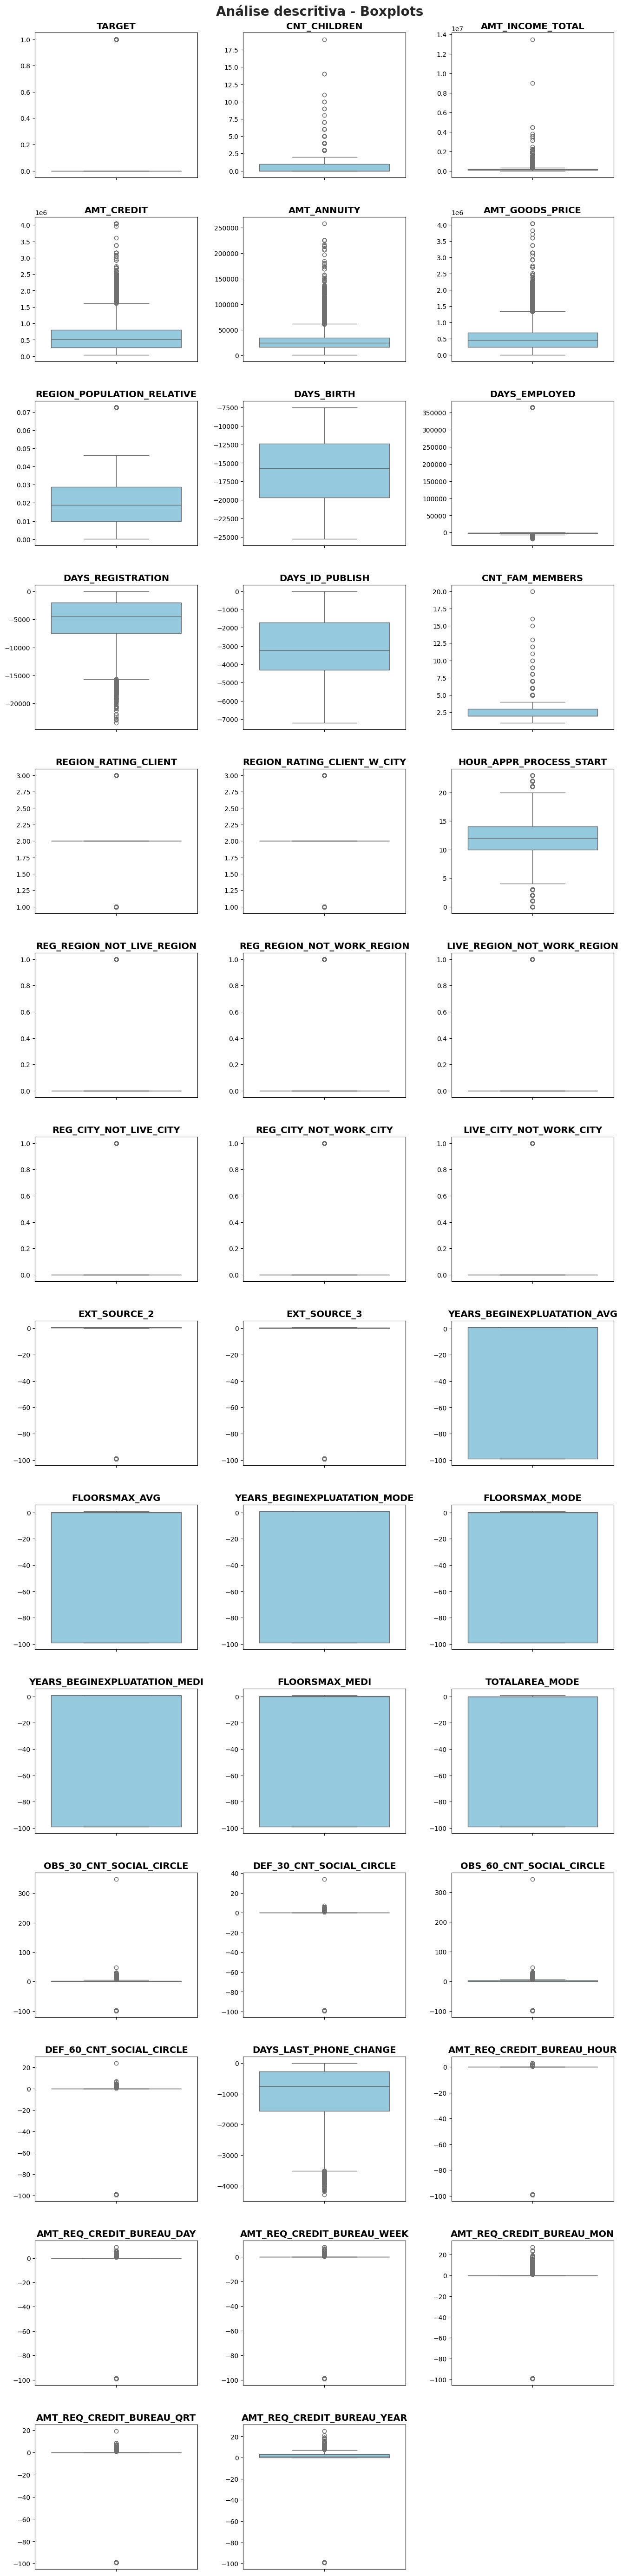

In [36]:
boxplots_var_num(df)

- Nas variáveis que eu desconfio que tenha uma maior relevância, podemos encontrar alguns outliers que irei investigar melhor
- Podemos ver que na variável Target o valor 1 é outlier, o que nos mostra que apenas uma pequena parcela das pessoas que fizeram empréstimo são inadimplentes

In [39]:
df['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
0     150712
1      42855
2      18775
3       2546
4        287
5         54
6         14
7          5
10         2
14         2
9          2
19         1
8          1
11         1
Name: count, dtype: int64

- Para esse caso seria interessante retornar para a área de negócio para entender se essas entradas de quantidade de filhos são valores errados ou realmente outliers

In [40]:
df[df['CNT_CHILDREN']>7]

TARGET NAME_CONTRACT_TYPE CODE_GENDER  CNT_CHILDREN  AMT_INCOME_TOTAL  \
24278        0         Cash loans           F            19     112500.000000   
29300        0         Cash loans           F            10      67500.000000   
36398        0         Cash loans           F            14      45000.000000   
68828        0         Cash loans           F            10      67500.000000   
75818        0         Cash loans           M            14     225000.000000   
85440        0         Cash loans           F             8     103500.000000   
91122        1         Cash loans           F             9     180000.000000   
112700       1         Cash loans           M             9     270000.000000   
139887       1         Cash loans           M            11     315000.000000   

           AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
24278   269550.000000 13891.500000    225000.000000          Family   
29300   117162.000000 12559.500000    103500.000000          Family   
36398   810000.000000 23814.000000    810000.000000   Unaccompanied   
68828    92655.000000  5301.000000     76500.000000   Unaccompanied   
75818  1085058.000000 55530.000000    891000.000000        Children   
85440   239850.000000 23719.500000    225000.000000          Family   
91122   640080.000000 31131.000000    450000.000000   Unaccompanied   
112700  526491.000000 22261.500000    454500.000000   Unaccompanied   
139887 1007761.500000 38515.500000    927000.000000   Unaccompanied   

            NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
24278                Working  Secondary / secondary special   
29300                Working  Secondary / secondary special   
36398              Pensioner  Secondary / secondary special   
68828   Commercial associate               Higher education   
75818                Working  Secondary / secondary special   
85440                Working  Secondary / secondary special   
91122   Commercial associate               Higher education   
112700               Working  Secondary / secondary special   
139887               Working  Secondary / secondary special   

          NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
24278   Single / not married    House / apartment                    0.007020   
29300                Married    House / apartment                    0.018209   
36398                Married    House / apartment                    0.008625   
68828                Married    House / apartment                    0.018850   
75818              Separated    House / apartment                    0.031329   
85440                Married    House / apartment                    0.031329   
91122   Single / not married  Municipal apartment                    0.006629   
112700        Civil marriage    House / apartment                    0.015221   
139887               Married    House / apartment                    0.010643   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
24278       -11057          -1853       -3096.000000             -745   
29300       -15052          -1427       -4447.000000            -4462   
36398       -20308         365243      -12416.000000            -3829   
68828       -11458           -742       -5278.000000            -1186   
75818       -17754          -1689       -7149.000000            -1298   
85440       -11167          -3543       -3017.000000            -3431   
91122       -10929          -1042        -950.000000            -3447   
112700      -14718          -5011       -3530.000000            -4643   
139887      -17308           -198       -3940.000000             -844   

             OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
24278   Waiters/barmen staff        20.000000                     2   
29300                Missing        12.000000                     3   
36398                Missing        16.000000                     2   
68828             Core staff 

- Investigando os valores discrepantes de Days employed

In [44]:
df['DAYS_EMPLOYED'].max()

365243

In [46]:
len(df[df['DAYS_EMPLOYED'] == df['DAYS_EMPLOYED'].max()])

38716

In [50]:
max_value = df['DAYS_EMPLOYED'].max()
df[df['DAYS_EMPLOYED'] == max_value].head(15)

TARGET NAME_CONTRACT_TYPE CODE_GENDER  CNT_CHILDREN  AMT_INCOME_TOTAL  \
4        0         Cash loans           F             0     112500.000000   
8        0         Cash loans           F             0     135000.000000   
13       0         Cash loans           F             0     121500.000000   
19       0         Cash loans           F             0      67500.000000   
20       0         Cash loans           F             0      99000.000000   
21       0         Cash loans           F             0      94500.000000   
23       0         Cash loans           M             0     135900.000000   
28       0         Cash loans           F             0     180000.000000   
29       0         Cash loans           F             0      90000.000000   
30       0         Cash loans           M             0     135000.000000   
45       0         Cash loans           M             0     112500.000000   
49       0         Cash loans           F             0     121500.000000   
56       0         Cash loans           F             0      81000.000000   
58       0         Cash loans           F             0      83250.000000   
59       0         Cash loans           F             0      99000.000000   

      AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
4  729792.000000 37390.500000    630000.000000    Unaccompanied   
8  296280.000000 12681.000000    225000.000000    Unaccompanied   
13 945000.000000 40167.000000    945000.000000    Unaccompanied   
19 679981.500000 27094.500000    679981.500000    Unaccompanied   
20 414000.000000 23247.000000    414000.000000  Spouse, partner   
21 152820.000000 15016.500000    135000.000000    Unaccompanied   
23 229500.000000 14796.000000    229500.000000    Unaccompanied   
28 673875.000000 19831.500000    562500.000000    Unaccompanied   
29 239850.000000 23494.500000    225000.000000    Unaccompanied   
30 573628.500000 22878.000000    463500.000000    Unaccompanied   
45 900000.000000 26446.500000    900000.000000  Spouse, partner   
49 332842.500000 12082.500000    234000.000000    Unaccompanied   
56 553806.000000 21960.000000    495000.000000    Unaccompanied   
58 566055.000000 18387.000000    472500.000000    Unaccompanied   
59 254700.000000 14350.500000    225000.000000    Unaccompanied   

   NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
4         Pensioner  Secondary / secondary special        Civil marriage   
8         Pensioner  Secondary / secondary special        Civil marriage   
13        Pensioner  Secondary / secondary special               Married   
19        Pensioner  Secondary / secondary special  Single / not married   
20        Pensioner  Secondary / secondary special               Married   
21        Pensioner  Secondary / secondary special               Married   
23        Pensioner  Secondary / secondary special               Married   
28        Pensioner  Secondary / secondary special             Separated   
29        Pensioner  Secondary / secondary special               Married   
30        Pensioner  Secondary / secondary special               Married   
45        Pensioner  Secondary / secondary special               Married   
49        Pensioner  Secondary / secondary special                 Widow   
56        Pensioner  Secondary / secondary special               Married   
58        Pensioner  Secondary / secondary special               Married   
59        Pensioner  Secondary / secondary special  Single / not married   

      NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
4     House / apartment                    0.046220      -19666   
8     House / apartment                    0.006305      -21927   
13    House / apartment                    0.026392      -20967   
19    House / apartment                    0.035792      -20968   
20    House / apartment                    0.028663      -20883   
21    House / apartment                    0.015221      -22928   
23    House 

In [54]:
df[df['DAYS_EMPLOYED']==max_value]['NAME_INCOME_TYPE'].count()

np.int64(38716)

In [55]:
df[df['DAYS_EMPLOYED']==max_value]['NAME_INCOME_TYPE'].unique()

array(['Pensioner', 'Unemployed'], dtype=object)

- Quando os cliente são aposentados ou desempregados o valor padrão para o Days Employed é de 365243

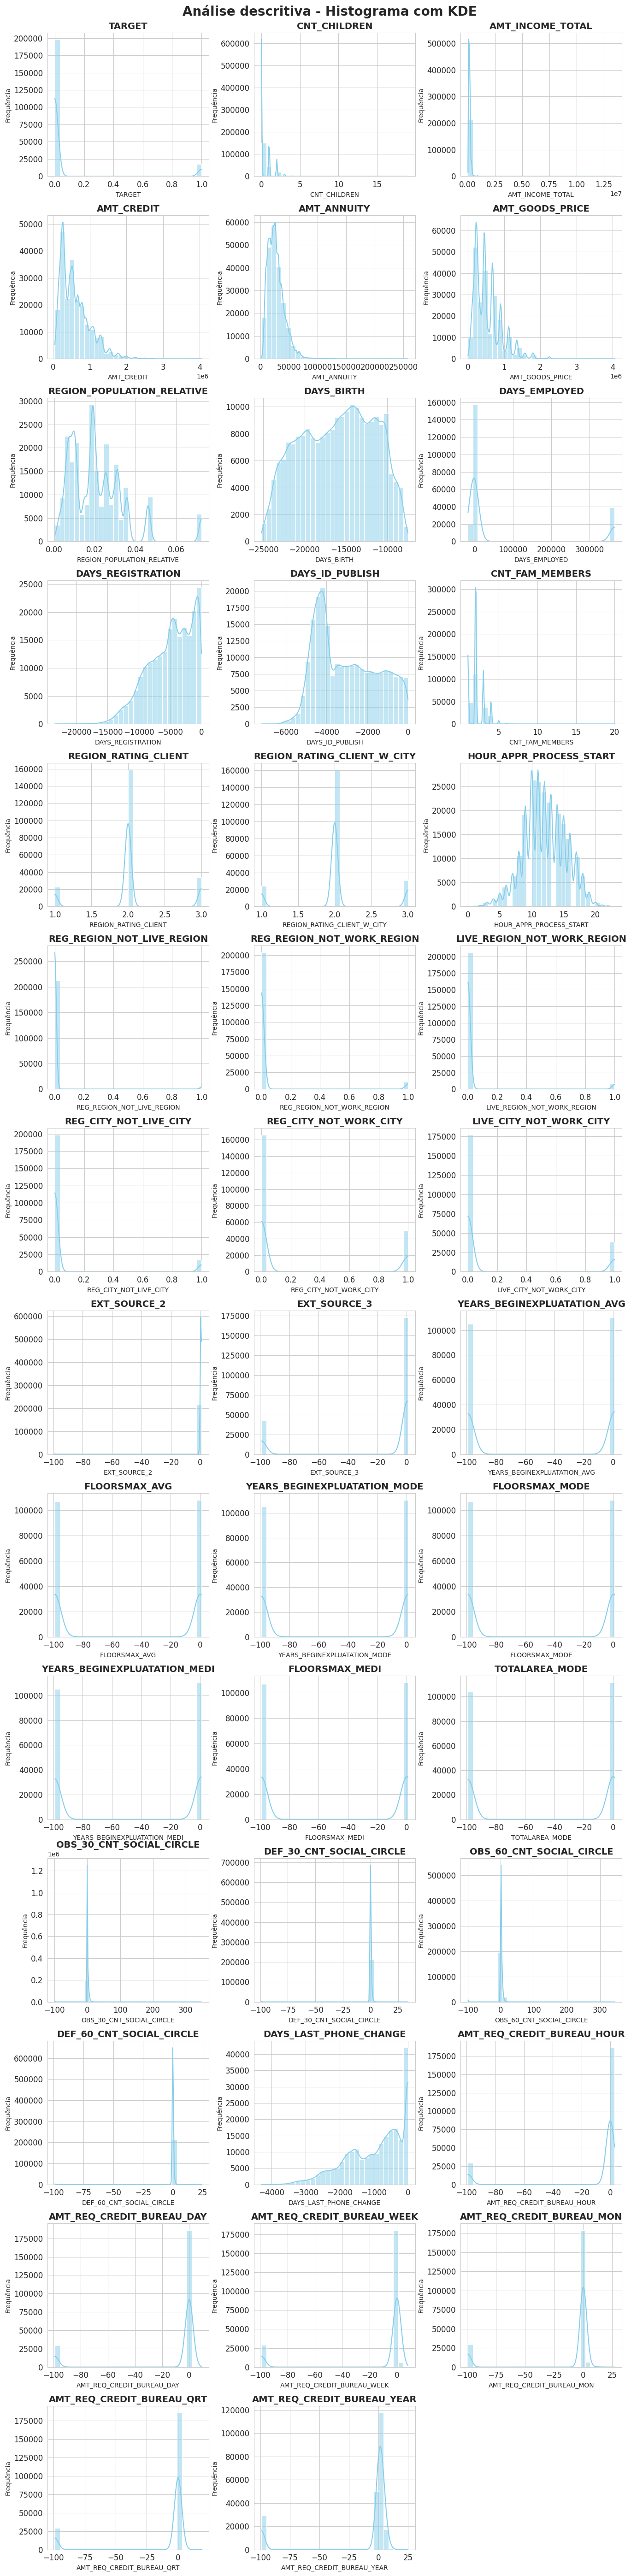

In [56]:
histograms_var_num(df)

In [76]:
df.describe()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL     AMT_CREDIT  \
count 215257.000000 215257.000000     215257.000000  215257.000000   
mean       0.080889      0.416637     168556.848346  599495.998425   
std        0.272666      0.719695     105855.718537  402898.914406   
min        0.000000      0.000000      25650.000000   45000.000000   
25%        0.000000      0.000000     112500.000000  270000.000000   
50%        0.000000      0.000000     144000.000000  514867.500000   
75%        0.000000      1.000000     202500.000000  808650.000000   
max        1.000000     19.000000   13500000.000000 4050000.000000   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count 215249.000000    215257.000000               215257.000000   
mean   27119.681762    538366.209626                    0.020869   
std    14522.021876    369955.284524                    0.013829   
min     1615.500000     40500.000000                    0.000290   
25%    16506.000000    238500.000000                    0.010006   
50%    24903.000000    450000.000000                    0.018850   
75%    34650.000000    679500.000000                    0.028663   
max   258025.500000   4050000.000000                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count 215257.000000  215257.000000      215257.000000    215257.000000   
mean  -16033.152241   63737.365791       -4979.871219     -2991.410296   
std     4361.858115  141210.765298        3522.665372      1508.956090   
min   -25229.000000  -17912.000000      -23416.000000     -7197.000000   
25%   -19681.000000   -2760.000000       -7478.000000     -4296.000000   
50%   -15749.000000   -1214.000000       -4495.000000     -3249.000000   
75%   -12410.000000    -290.000000       -2001.000000     -1717.000000   
max    -7489.000000  365243.000000           0.000000         0.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    215256.000000         215257.000000                215257.000000   
mean          2.153111              2.052519                     2.031330   
std           0.908398              0.509422                     0.502949   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          20.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            215257.000000               215257.000000   
mean                 12.063905                    0.015344   
std                   3.267196                    0.122919   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  14.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count               215257.000000                215257.000000   
mean                     0.051097                     0.040835   
std                      0.220196                     0.197908   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     0.000000   
max                      1.000000                     1.000000   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count           215257.000000           215257.000000   
mean                 0.078497                0.230218   
std                  0.268952                0.420973   
min                  0.000

**Observações**
- A quantidade de inadimplentes na nossa base é de 8%
- A média de filhos por pessoa que fez empréstimo é de 0,4, com um outlier de 19. Além disso podemos observar que 75% da base possuí até 1 filho, mostrando que a maioria das pessoas tem poucos ou nenhum filho.
- A renda média é de 168556, porém o desvio padrão também é alto devido a existência de outliers, olhando a mediana podemos observa que 50% da base ganha menos que 144000 anualmente. Podemos observar que 75% da base ganha até 202500 por ano. Olhando a amplitude dos salarios, podemos ver que existe uma diferença muito grande entre os que menos ganham e os que mais ganham
- Como o desvio padrão do AMT_CREDIT está muito alto, olhar a média não é a melhor opção, podemos observar que até 75% da base pede um empréstimo de até 808650, que é praticamente 4x mais do que o salario anual da mesma porcentagem da base. Olhando o maior empréstimo vs a maior renda anual, vemos um comportamento diferente, onde o maior empréstimo representa 30% da maior renda anual
- Vemos que 75% da base paga até 34560 por ano, o que por mês da uma média de 2880 por mês, representando 17% da renda mensal somente voltado ao pagamento do empréstimo.
- AMT_GOODS_PRICE podemos ver que o valor máximo do bem adquirido com o valor do empréstimo são iguais, indicando que para valores muito grandes o valor do bem tem que ser equivalente. Olhando a média, mediana e os quartis podemos observar que em todas elas o valor do empréstimo é menor que o valor do bem adquirido
- Em relação a idade (em dias desde o pedido do empréstimo), a média está próxima da mediana, indicando que não existem outliers tão grandes. Podemos notar que 75% da nossa base tem até 12410 dias de vida, equanto o maior valor (como está negativo olhamos o minimo) é de 25229 dias
- Na variável DAYS_EMPLOYED  75% da base está a poucos dias empregado (provavelmente em um novo emprego) até o dia do empréstimo, o que pode indicar que as pessoas que pediram empréstimo mudaram recentemente de emprego e podem estar passando alguma dificuldade
- Em média os pedidos de empréstimo são feitos no horário do almoço. 75% da base pede até as 14hrs

####**4.1.2 - Variáveis Categóricas**

In [77]:
df.describe(include='object')

NAME_CONTRACT_TYPE CODE_GENDER NAME_TYPE_SUITE NAME_INCOME_TYPE  \
count              215257      215257          215257           215257   
unique                  2           3               8                8   
top            Cash loans           F   Unaccompanied          Working   
freq               194663      141565          173791           111082   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
count                          215257             215257             215257   
unique                              5                  6                  6   
top     Secondary / secondary special            Married  House / apartment   
freq                           152634             137750             191042   

       OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  \
count           215257                     215257                  215257   
unique              19                          7                      58   
top            Missing                    TUESDAY  Business Entity Type 3   
freq             67409                      37706                   47560   

       EMERGENCYSTATE_MODE  
count               215257  
unique                   3  
top                     No  
freq                111573

**Observações**
- O tipo de contrato mais comum é do pagamento em dinheiro (194663)
- As mulheres foram as que mais realizaram empréstimo (141565)
- A maioria das pessoas que fizeram empréstimo estavam desacompanhadas (será que tomaram essa decisão escondidos dos familiares? 173791)
- A maioria dos que fizeram empréstimo são trabalhadores (NAME_INCOME_TYPE, 111082)
- A maioria que fez o empréstimo possui uma graduação máxima de Secondary /secondary special, que significa que fizeram até o ensino médio e ou cursos técnicos, é um ponto de atenção pois em pesquisas achei estudos dizendo que pessoas com maiores escolaridades possuem mais estabilidade nos empregos e uma compreensão maior dos seus gastos (152634)
- As pessoas que fizeram empréstimo em sua maioria eram casadas e moravam em casas/apartamentos (137750)

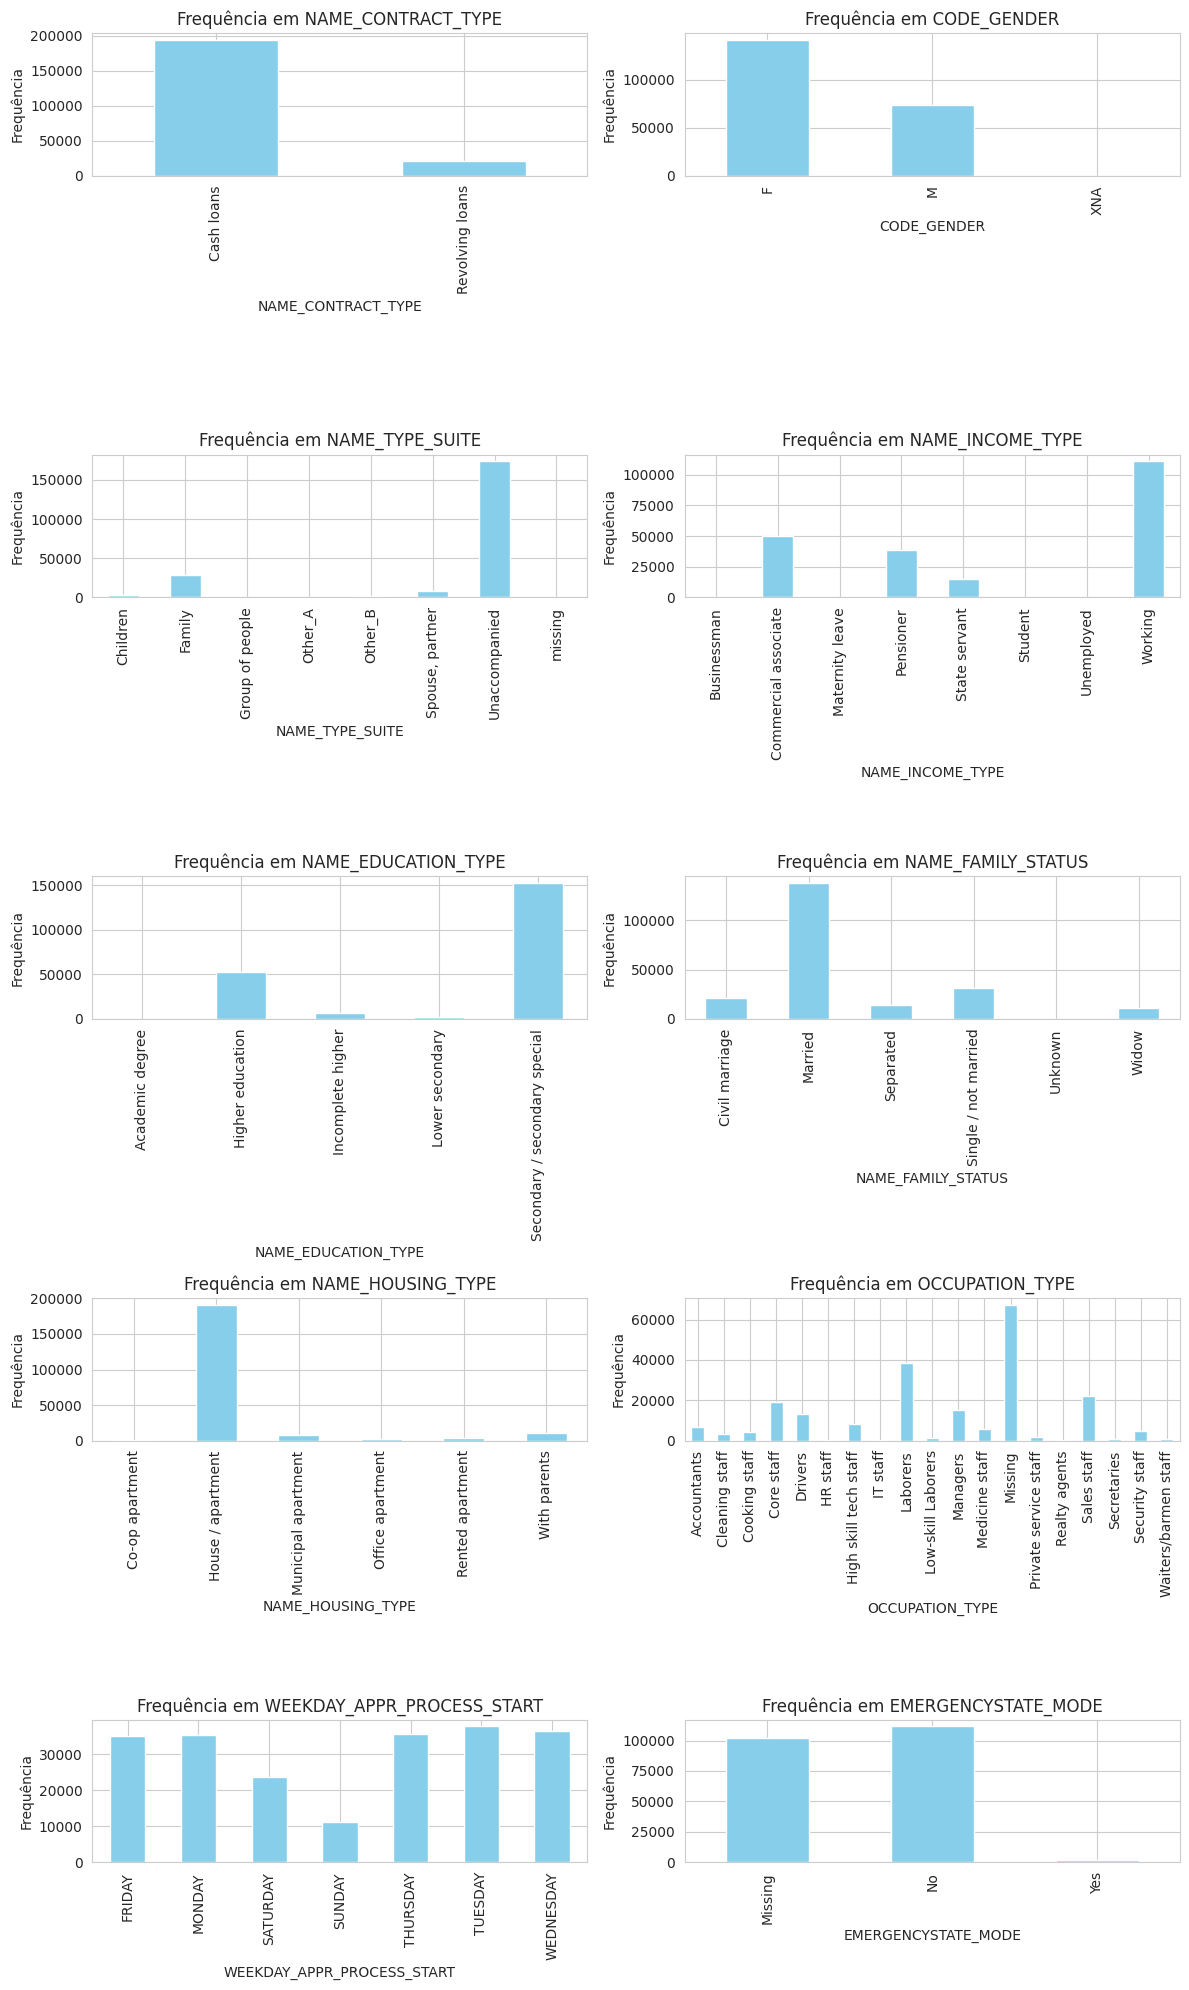

In [81]:
plot_categorical_frequency_pt(df)

**Observações**
- Podemos observar que a segunda maior frequência de NAME_INCOME_TYPE é o de Commercial associate, o que indica que pode ser empréstimos para autônomos ou parceiros comerciais
- Na educação a segunda maior frequência é Higher education, vou verificar posteriormente como a distribuição do Target se dá pela educação
- Podemos notar que o dia da semana que menos tem empréstimo é ao domingo, o que faz sentido já que não é comum a liberação de empréstimos nesse dia por segurança

###**4.2 - Análise Bivariada**
Irei investigar a relação da variável target com Quantidade de filhos, Renda média, a quantidade de empréstimo, o valor do bem adquirido com o empréstimo, idade, dias empregado, horários, tipo de contrato, sexo, pessoas acompanhadas no momento do pedido, name_income_type, escolaridade, status civil e o tipo de moradia

####**4.2.1 - Variáveis Numéricas e Categóricas**

In [112]:
def kdeplots_var_num_target(dataframe, target_column):
    """
    Plota gráficos kdeplot (Kernel Density Estimation) para todas as variáveis numéricas do DataFrame,
    discriminando as curvas de acordo com o valor da coluna target.

    :param dataframe: DataFrame contendo as variáveis numéricas e a coluna target.
    :param target_column: Nome da coluna target.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows * 4))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota kdeplots para cada coluna numérica, discriminando as curvas pelo valor da coluna target
    for i, column in enumerate(numeric_columns):
        sns.kdeplot(data=dataframe[dataframe[target_column] == 1][column], ax=axes[i//3, i%3], color="blue", label="1", fill=True, warn_singular=False)
        sns.kdeplot(data=dataframe[dataframe[target_column] == 0][column], ax=axes[i//3, i%3], color="red", label="0", fill=True, warn_singular=False)
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('Densidade')
        axes[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)
        if i == 0:
            axes[i//3, i%3].legend(title=target_column)

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Gráfico KDE por Target", fontsize=20, fontweight='bold', y=1.00)

<ipython-input-112-6c1adfb20d11>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i//3, i%3].legend(title=target_column)


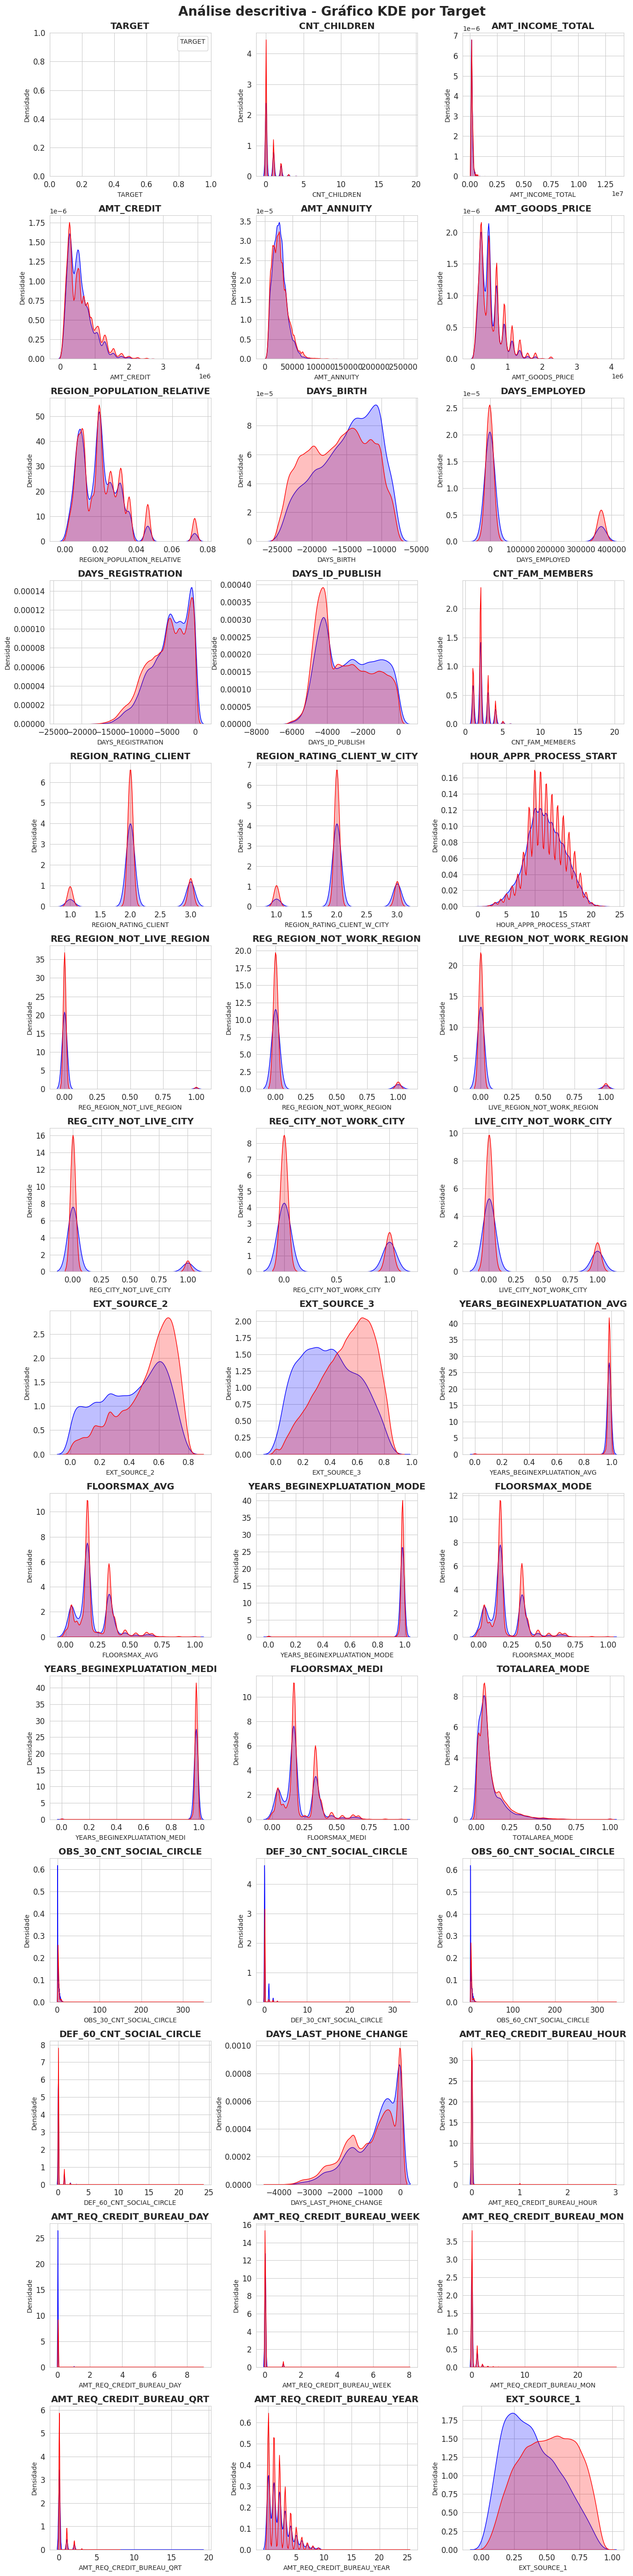

In [113]:
kdeplots_var_num_target(df, 'TARGET')

**Observações**
- Observar mais atentamente o AMT_CREDIT, DAYS_BIRTH, DAYS_ID_PUBLISH, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, EX_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cat_vs_target_cutoff(dataframe, target_column, cutoff=10):
    """
    Plota gráficos de barras para analisar as variáveis categóricas em relação ao target,
    limitando o número de variáveis de acordo com um valor de cutoff.

    :param dataframe: DataFrame contendo as variáveis categóricas e a coluna target.
    :param target_column: Nome da coluna target.
    :param cutoff: Valor de cutoff para limitar o número de variáveis categóricas plotadas (padrão é 10).
    """
    # Seleciona apenas colunas categóricas
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns

    # Filtra as colunas com base no cutoff
    categorical_columns_filtered = [col for col in categorical_columns if dataframe[col].nunique() <= cutoff]

    # Define o número de linhas e colunas para os subplots
    n_rows = len(categorical_columns_filtered) // 3 + (len(categorical_columns_filtered) % 3 > 0)
    n_cols = min(len(categorical_columns_filtered), 3)

    # Cria subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Loop pelas colunas categóricas filtradas
    for i, column in enumerate(categorical_columns_filtered):
        # Calcula proporções de cada categoria para cada valor do target
        prop_df = (dataframe.groupby([column, target_column]).size() / dataframe.groupby(target_column).size()).unstack()

        # Plota o gráfico de barras
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i]
        prop_df.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(column, fontsize=14)
        ax.set_ylabel('Proporção')
        ax.tick_params(axis='both', which='major', labelsize=12)

        # Rotaciona as labels do eixo x
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Ajusta o layout do subplot
        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # Remove subplots vazios
    for j in range(len(categorical_columns_filtered), n_rows * n_cols):
        if n_rows > 1:
            fig.delaxes(axes.flatten()[j])
        else:
            fig.delaxes(axes)

    # Adiciona título principal
    fig.suptitle("Análise de Variáveis Categóricas em relação ao Target", fontsize=20, fontweight='bold', y=1.02)

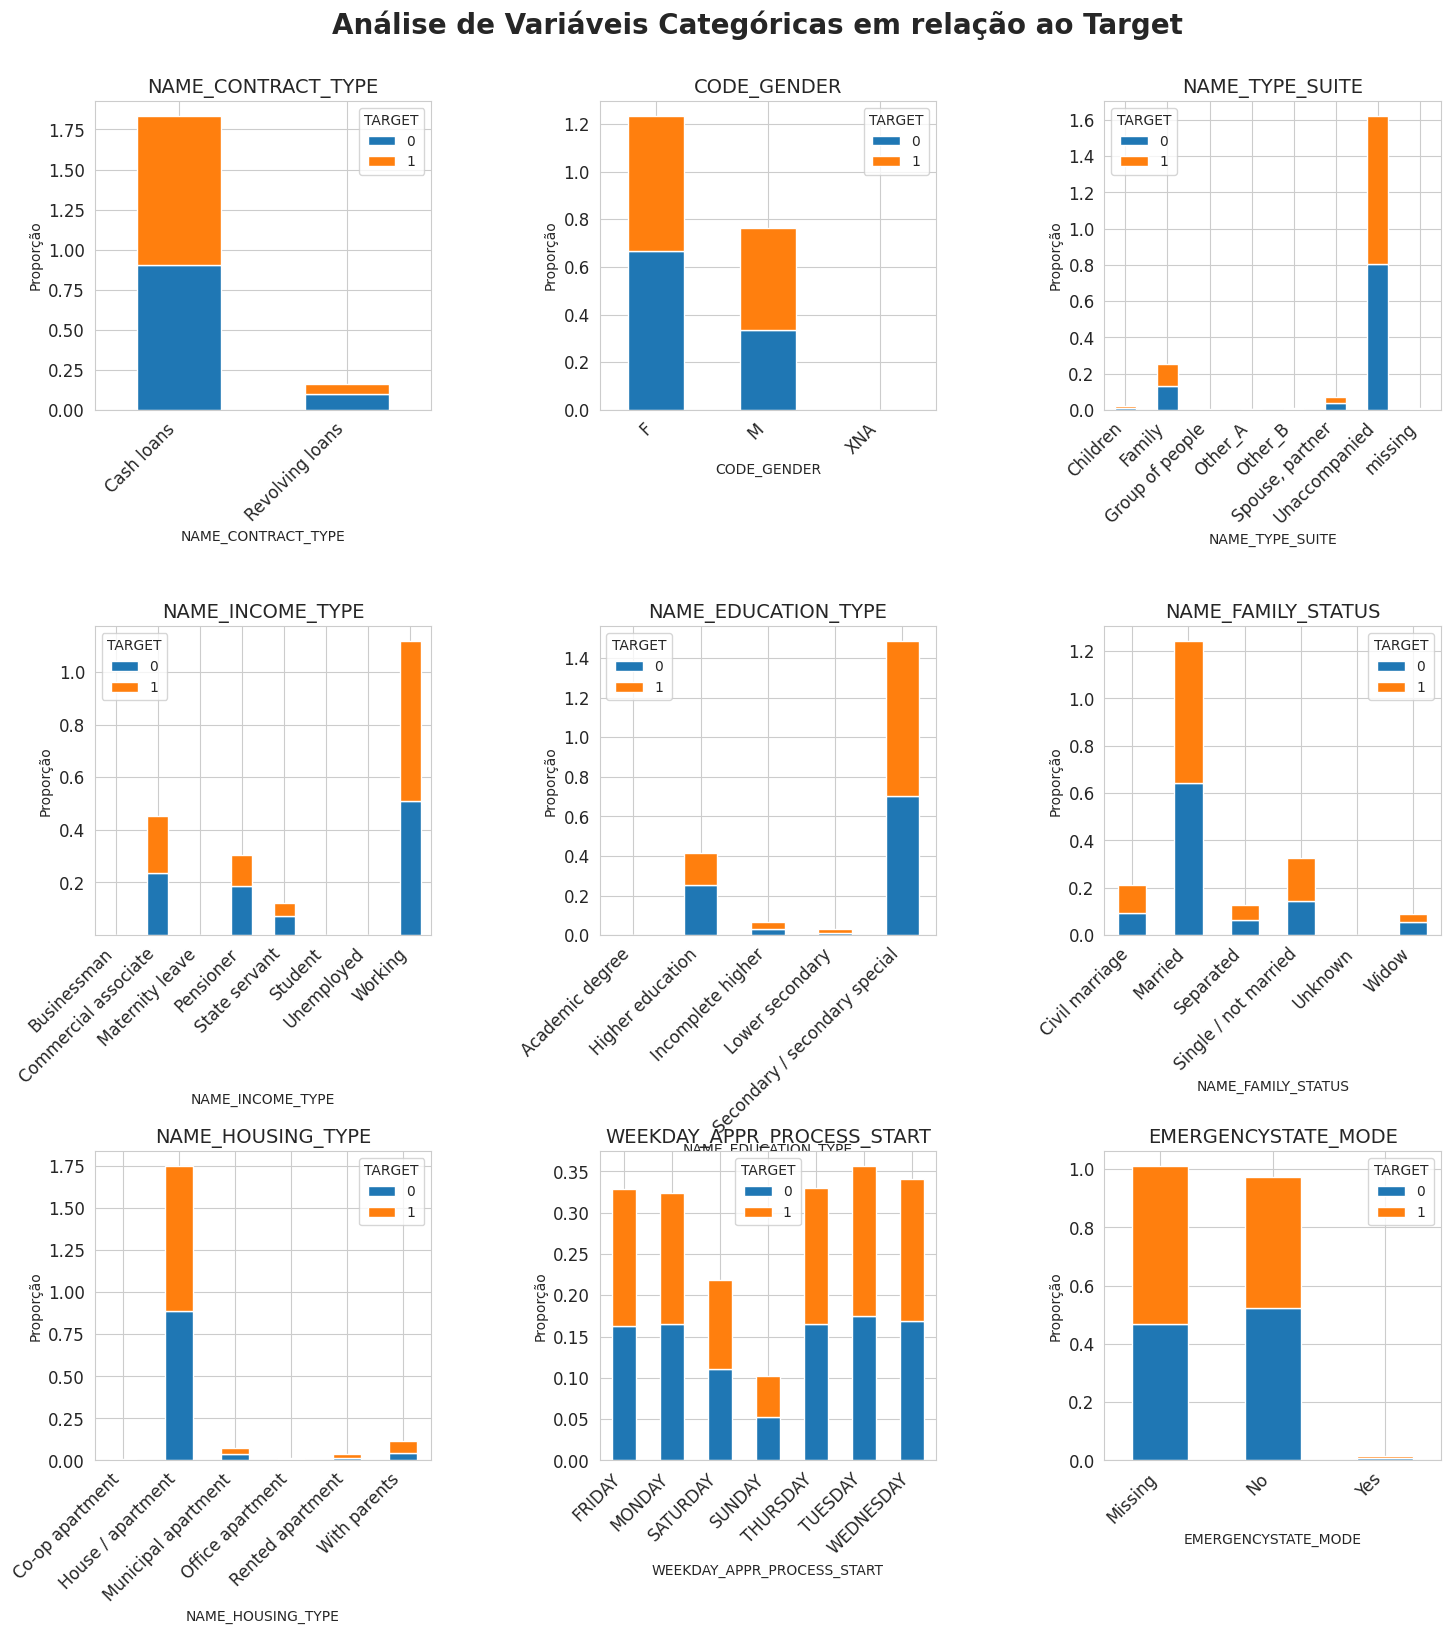

In [18]:
plot_cat_vs_target_cutoff(df, 'TARGET', cutoff=8)
plt.show()

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cat_vs_target_percentage(dataframe, target_column, cutoff=10):
    """
    Plota gráficos de barras empilhadas 100% para analisar as variáveis categóricas em relação ao target,
    limitando o número de variáveis de acordo com um valor de cutoff.

    :param dataframe: DataFrame contendo as variáveis categóricas e a coluna target.
    :param target_column: Nome da coluna target.
    :param cutoff: Valor de cutoff para limitar o número de variáveis categóricas plotadas (padrão é 10).
    """
    # Seleciona apenas colunas categóricas
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns

    # Filtra as colunas com base no cutoff
    categorical_columns_filtered = [col for col in categorical_columns if dataframe[col].nunique() <= cutoff]

    # Define o número de linhas e colunas para os subplots
    n_rows = len(categorical_columns_filtered) // 3 + (len(categorical_columns_filtered) % 3 > 0)
    n_cols = min(len(categorical_columns_filtered), 3)

    # Cria subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Loop pelas colunas categóricas filtradas
    for i, column in enumerate(categorical_columns_filtered):
        # Calcula proporções de cada categoria para cada valor do target
        prop_df = (dataframe.groupby([column, target_column]).size() / dataframe.groupby(column).size()).unstack()

        # Plota o gráfico de barras empilhadas 100%
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i]
        prop_df.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(column, fontsize=14)
        ax.set_ylabel('Porcentagem')
        ax.tick_params(axis='both', which='major', labelsize=12)

        # Rotaciona as labels do eixo x
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Ajusta o layout do subplot
        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # Remove subplots vazios
    for j in range(len(categorical_columns_filtered), n_rows * n_cols):
        if n_rows > 1:
            fig.delaxes(axes.flatten()[j])
        else:
            fig.delaxes(axes)

    # Adiciona título principal
    fig.suptitle("Análise de Variáveis Categóricas em relação ao Target (Porcentagem)", fontsize=20, fontweight='bold', y=1.02)

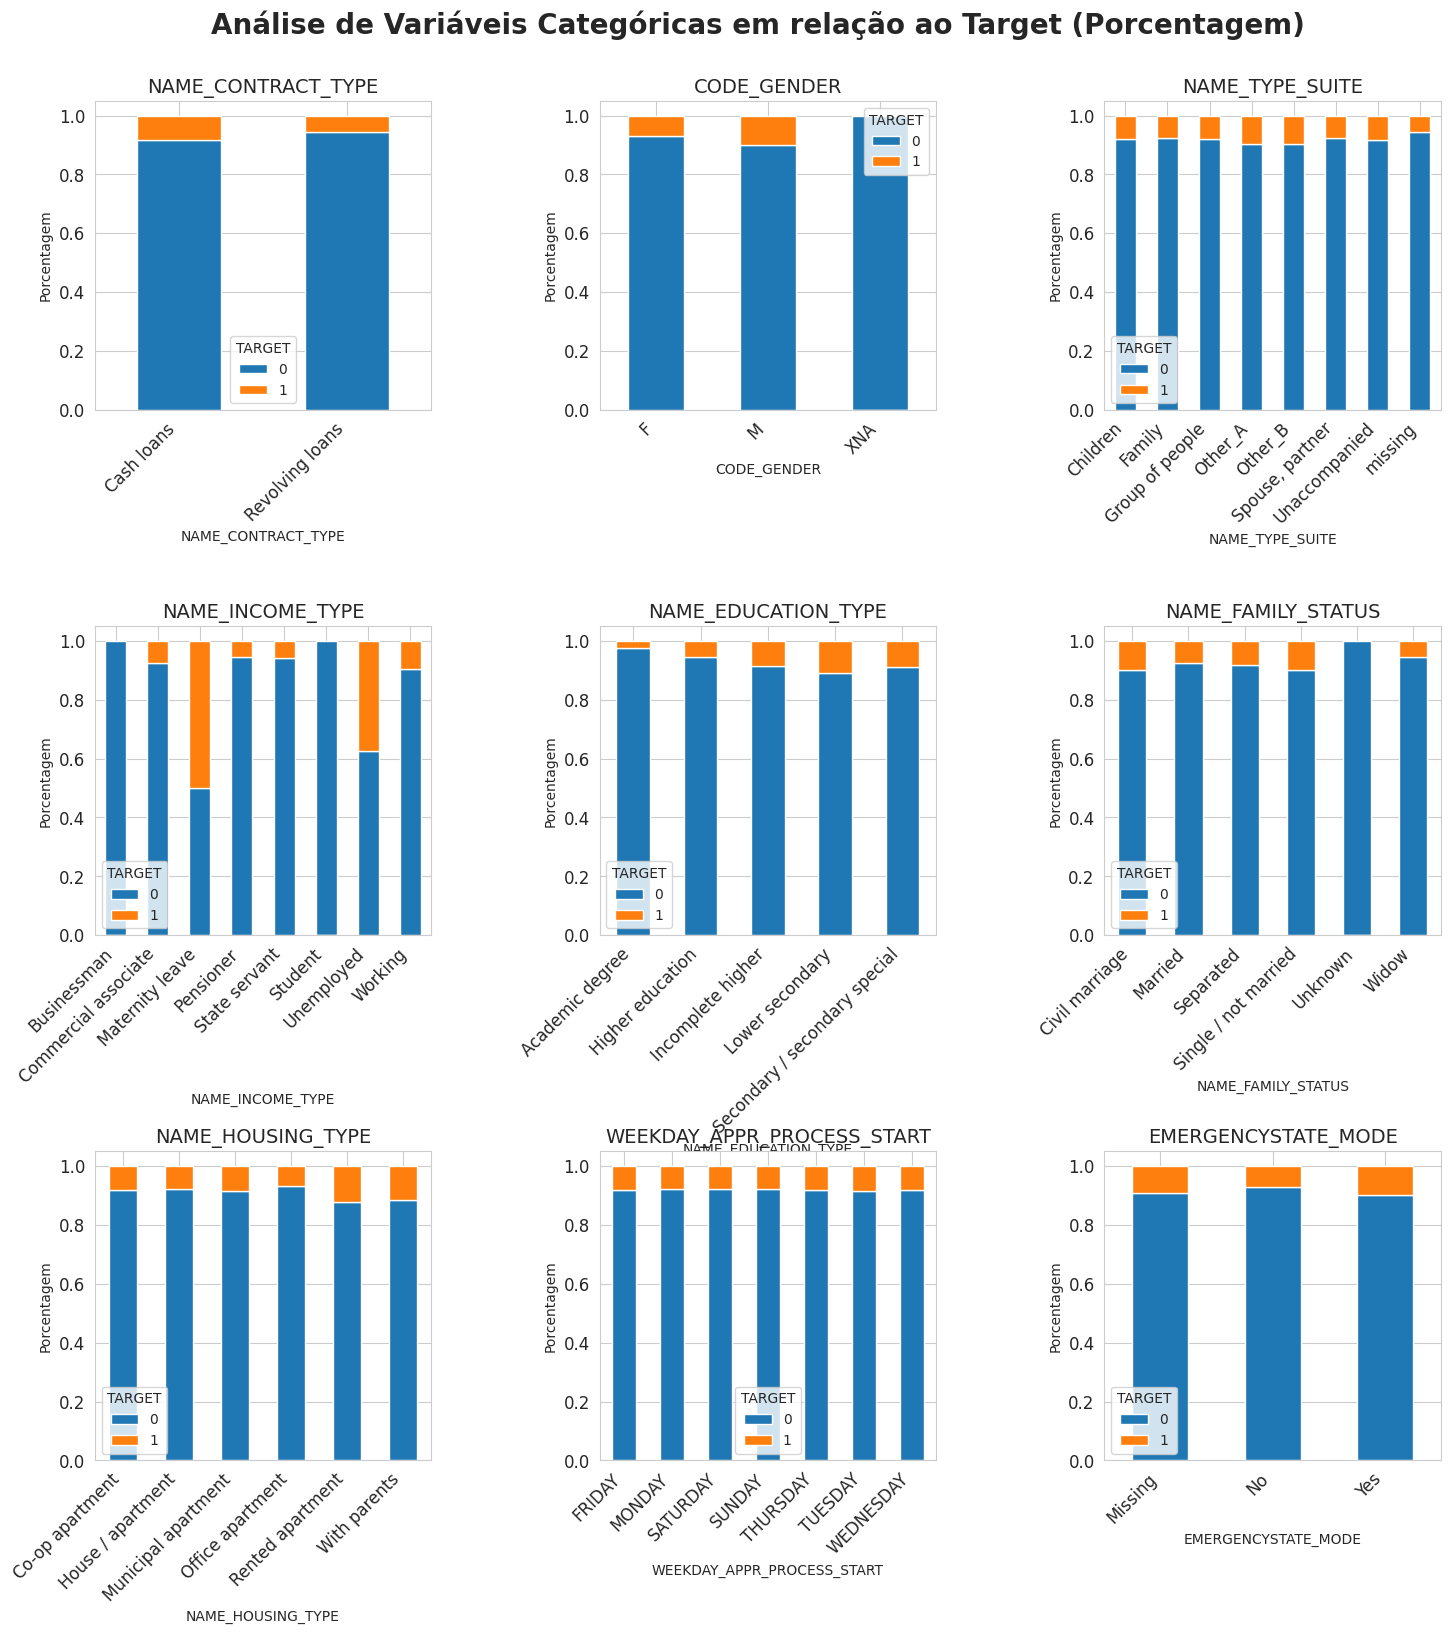

In [20]:
plot_cat_vs_target_percentage(df, 'TARGET', cutoff=8)
plt.show()

**Observações**
- Com os dois gráficos podemos ter uma noção de quais variáveis seriam boas variáveis preditivas ou que nos trazem boas informações, como NAME_INCOME_TYPE, porém precisamos tomar cuidado com a quantidade de dados, pois o Unemployed e Maternity leave representam uma parcela muito pequena

In [21]:
def pod_count_categorias(df, columns):
    if isinstance(columns, str):
        columns = [columns]  # Se apenas uma variável for passada, converte para lista

    # Calcula a contagem de valores e converte em DataFrame
    count_df = df[columns].value_counts().reset_index()
    count_df.columns = columns + ['Count']

    # Calcula a porcentagem de cada valor
    count_df['Percentage'] = (count_df['Count'] / count_df['Count'].sum()) * 100

    # Calcula a soma total da coluna de contagem
    total_count = count_df['Count'].sum()

    # Adiciona a soma total ao DataFrame
    total_row = pd.DataFrame({columns[0]: ['Total'], 'Count': [total_count], 'Percentage': [100]})
    count_df = pd.concat([count_df, total_row], ignore_index=True)

    return count_df

####**4.2.2 - Analisando as variáveis para Inadimplentes**

In [114]:
#Substituindo os valores de 36k que representam aposentados ou desempregados por um float (-0.1)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].astype(float)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, -0.1)

In [59]:
df['DAYS_EMPLOYED'].min(), df['DAYS_EMPLOYED'].max()

(-17912.0, 0.0)

In [22]:
pod_count_categorias(df,'TARGET')

TARGET   Count  Percentage
0      0  197845   91.911064
1      1   17412    8.088936
2  Total  215257  100.000000

In [24]:
pod_count_categorias(df,'NAME_CONTRACT_TYPE')

NAME_CONTRACT_TYPE   Count  Percentage
0         Cash loans  194663   90.432831
1    Revolving loans   20594    9.567169
2              Total  215257  100.000000

In [26]:
pod_count_categorias(df[df['NAME_CONTRACT_TYPE'] == 'Cash loans'], 'TARGET')

TARGET   Count  Percentage
0      0  178371   91.630664
1      1   16292    8.369336
2  Total  194663  100.000000

In [27]:
pod_count_categorias(df[df['NAME_CONTRACT_TYPE'] == 'Revolving loans'], 'TARGET')

TARGET  Count  Percentage
0      0  19474   94.561523
1      1   1120    5.438477
2  Total  20594  100.000000

**Observações**
- Temos 8% de inadimplentes no Cash Loans e 5% no Revolvnig loans.
- Dos 100% de inadimplentes (17412), 93% está em Cash Loans enquanto os outros 7 em Revolving loans

In [115]:
df_inadimplente = df[df['TARGET']==1]


In [116]:
def convert_to_years(days):
    if days >= 0:
        return days / 365
    else:
        return (days * -1) / 365

df_inadimplente['IDADE_ANOS'] = df_inadimplente['DAYS_BIRTH'].apply(convert_to_years)
df_inadimplente['EMPREGADO_ANOS'] = df_inadimplente['DAYS_EMPLOYED'].apply(convert_to_years)

<ipython-input-116-191470300cf1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inadimplente['IDADE_ANOS'] = df_inadimplente['DAYS_BIRTH'].apply(convert_to_years)
<ipython-input-116-191470300cf1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inadimplente['EMPREGADO_ANOS'] = df_inadimplente['DAYS_EMPLOYED'].apply(convert_to_years)


In [117]:
df_inadimplente.describe()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL     AMT_CREDIT  \
count 17412.000000  17412.000000      17412.000000   17412.000000   
mean      1.000000      0.466115     161324.257495  557346.189438   
std       0.000000      0.757821      89445.758195  346410.484688   
min       1.000000      0.000000      27000.000000   45000.000000   
25%       1.000000      0.000000     112500.000000  284400.000000   
50%       1.000000      0.000000     135000.000000  495985.500000   
75%       1.000000      1.000000     202500.000000  729792.000000   
max       1.000000     11.000000    3150000.000000 4027680.000000   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  17412.000000     17399.000000                17412.000000   
mean   26533.812715    488656.018248                    0.019133   
std    12471.984023    311337.812830                    0.011937   
min     2722.500000     45000.000000                    0.000533   
25%    17465.625000    238500.000000                    0.009630   
50%    25332.750000    450000.000000                    0.018634   
75%    32998.500000    675000.000000                    0.025164   
max   149211.000000   3600000.000000                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  17412.000000   17412.000000       17412.000000     17412.000000   
mean  -14880.218068   -1596.582110       -4482.784804     -2724.716575   
std     4194.410201    1839.148270        3296.532554      1517.936884   
min   -25168.000000  -16069.000000      -22928.000000     -6207.000000   
25%   -18006.250000   -2158.000000       -6650.750000     -4118.000000   
50%   -14282.000000   -1030.000000       -4050.500000     -2783.500000   
75%   -11392.000000    -376.750000       -1679.000000     -1386.000000   
max    -7678.000000       0.000000           0.000000         0.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count     17412.000000          17412.000000                 17412.000000   
mean          2.184585              2.152596                     2.134562   
std           0.952395              0.505870                     0.501088   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          13.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count             17412.000000                17412.000000   
mean                 11.826786                    0.017861   
std                   3.297456                    0.132451   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  14.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count                17412.000000                 17412.000000   
mean                     0.055938                     0.042672   
std                      0.229809                     0.202122   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     0.000000   
max                      1.000000                     1.000000   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count            17412.000000            17412.000000   
mean                 0.119688                0.301631   
std                  0.324605                0.458979   
min                  0.000000     

CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, DAYS_BIRTH, DAYS_EMPLOYED,
CODE_GENDER, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS

**Observações**
- CNT_CHILDREN: As pessoas inadimplentes possuem em média 0.4 filhos, onde 75% da base tem até um filho, existindo um outlier de 11.
- AMT_INCOME_TOTAL: a média salarial é de 161324, porém com um desvio padrão muito alto por conta da existência de um salario de 3150000, 75% da base ganha até 202500 e uma mediana de 135000
- AMT_CREDIT: Média de 557346, com desvio padrão alto por conta do valor maximo de 4027680, uma mediana de 495985 e 75% da base até 729792.
- AMT_ANNUITY: uma média de 26533, mediana de 25332, o que da por mês em torno de 2k, representando 17% do salario mensal. Eles pedem créditos que são 3,4x maior que o salario
- AMT_GOODS_PRICE: Nesse caso todas as métricas mostram que todos os bens comprados com o empréstimo possui um valor inferior ao que foi usado
- IDADE: uma média de 41 anos, com um desvio padrão relativamente baixo de 11, onde 75% da base tem menos que 50 anos (o que pode indicar que pessoas inadimplentes são pessoas mais jovens)
- TEMPO EMPREGADO: uma média de 4 anos empregado, onde 75% da base tem até 5.9 anos de emprego
- EXT_SOURCE_1: 0.38 de média, com 75% da base até 0.53
- EXT_SOURCE_2: 0.41 de média, com 75% da base até 0.59
- EXT_SOURCE_3: 0.39 de média, com 75% da base até 0.55


In [123]:
print(f"Nulos em EXT_SOURCE_1 = {df_inadimplente['EXT_SOURCE_1'].isna().sum()}")
print(f"Nulos em EXT_SOURCE_2 = {df_inadimplente['EXT_SOURCE_2'].isna().sum()}")
print(f"Nulos em EXT_SOURCE_3 = {df_inadimplente['EXT_SOURCE_3'].isna().sum()}")

Nulos em EXT_SOURCE_1 = 10310
Nulos em EXT_SOURCE_2 = 36
Nulos em EXT_SOURCE_3 = 4021


In [34]:
df_inadimplente.describe(include='object')

NAME_CONTRACT_TYPE CODE_GENDER NAME_TYPE_SUITE NAME_INCOME_TYPE  \
count               17412       17412           17412            17412   
unique                  2           2               8                6   
top            Cash loans           F   Unaccompanied          Working   
freq                16292        9923           14231            10625   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
count                           17412              17412              17412   
unique                              5                  5                  6   
top     Secondary / secondary special            Married  House / apartment   
freq                            13662              10448              14947   

       OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  \
count            17412                      17412                   17412   
unique              19                          7                      58   
top            Missing                    TUESDAY  Business Entity Type 3   
freq              4384                       3161                    4444   

       EMERGENCYSTATE_MODE  
count                17412  
unique                   3  
top                Missing  
freq                  9434

**Observações**
- NAME_CONTRACT_TYPE: podemos observar que o Cash loans é o tipo de contrato onde mais ocorreceram inadimplencias
- CODE_GENDER: As mulheres desacompanhadas foram as mais inadimplentes
- A maioria deles com o name_type: Working com apenas o ensino médio/técnologo completo
- A maioria deles são casados e moram em casas/apartamentos


In [37]:
pod_count_categorias(df_inadimplente, ['OCCUPATION_TYPE'])

OCCUPATION_TYPE  Count  Percentage
0                 Missing   4384   25.178038
1                Laborers   4126   23.696301
2             Sales staff   2157   12.388008
3                 Drivers   1447    8.310361
4              Core staff   1242    7.133012
5                Managers    943    5.415805
6          Security staff    506    2.906042
7   High skill tech staff    487    2.796922
8           Cooking staff    432    2.481048
9          Medicine staff    395    2.268550
10         Cleaning staff    330    1.895245
11            Accountants    328    1.883758
12     Low-skill Laborers    250    1.435791
13  Private service staff    126    0.723639
14   Waiters/barmen staff    105    0.603032
15            Secretaries     61    0.350333
16          Realty agents     43    0.246956
17               IT staff     27    0.155065
18               HR staff     23    0.132093
19                  Total  17412  100.000000

- Aqui notamos que a maioria dos inadimplentes não possuem a informação de ocupação, enquanto o segundo lugar fica com laborers

In [38]:
pod_count_categorias(df_inadimplente, ['NAME_INCOME_TYPE'])

NAME_INCOME_TYPE  Count  Percentage
0               Working  10625   61.021135
1  Commercial associate   3812   21.892947
2             Pensioner   2091   12.008959
3         State servant    877    5.036756
4            Unemployed      6    0.034459
5       Maternity leave      1    0.005743
6                 Total  17412  100.000000

In [39]:
pod_count_categorias(df_inadimplente, ['NAME_EDUCATION_TYPE'])

NAME_EDUCATION_TYPE  Count  Percentage
0  Secondary / secondary special  13662   78.463129
1               Higher education   2851   16.373765
2              Incomplete higher    607    3.486102
3                Lower secondary    289    1.659775
4                Academic degree      3    0.017229
5                          Total  17412  100.000000

In [76]:
pod_count_categorias(df_inadimplente, 'NAME_FAMILY_STATUS')

NAME_FAMILY_STATUS  Count  Percentage
0               Married  10448   60.004595
1  Single / not married   3146   18.067999
2        Civil marriage   2062   11.842408
3             Separated   1125    6.461061
4                 Widow    631    3.623938
5                 Total  17412  100.000000

In [78]:
pod_count_categorias(df_inadimplente,'NAME_HOUSING_TYPE')

NAME_HOUSING_TYPE  Count  Percentage
0    House / apartment  14947   85.843097
1         With parents   1208    6.937744
2  Municipal apartment    645    3.704342
3     Rented apartment    422    2.423616
4     Office apartment    126    0.723639
5      Co-op apartment     64    0.367563
6                Total  17412  100.000000

In [130]:
pod_count_categorias(df_inadimplente,'AMT_REQ_CREDIT_BUREAU_DAY')

AMT_REQ_CREDIT_BUREAU_DAY  Count  Percentage
0                  0.000000  14292   99.332777
1                  1.000000     86    0.597720
2                  2.000000      8    0.055602
3                  3.000000      1    0.006950
4                  4.000000      1    0.006950
5                     Total  14388  100.000000

In [135]:
df['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts()

AMT_REQ_CREDIT_BUREAU_DAY
0.000000    185102
1.000000       881
2.000000        68
3.000000        30
4.000000        13
5.000000         6
6.000000         5
9.000000         2
Name: count, dtype: int64

In [136]:
df['AMT_REQ_CREDIT_BUREAU_QRT'].value_counts()

AMT_REQ_CREDIT_BUREAU_QRT
0.000000     150571
1.000000      23686
2.000000      10249
3.000000       1204
4.000000        328
5.000000         40
6.000000         18
8.000000          5
7.000000          5
19.000000         1
Name: count, dtype: int64

In [138]:
df_inadimplente[df_inadimplente['NAME_EDUCATION_TYPE']=='Higher education']['AMT_INCOME_TOTAL'].mean()

np.float64(197027.1855489302)

####**4.2.3 - Analisando as variáveis para Adimplentes**

In [ ]:
def convert_to_years(days):
    if days >= 0:
        return days / 365
    else:
        return (days * -1) / 365

In [124]:
df_adimplentes = df[df['TARGET'] == 0]

In [125]:
df_adimplentes['IDADE_ANOS'] = df_adimplentes['DAYS_BIRTH'].apply(convert_to_years)

<ipython-input-125-3274ea994d6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adimplentes['IDADE_ANOS'] = df_adimplentes['DAYS_BIRTH'].apply(convert_to_years)


In [126]:
df_adimplentes['EMPREGADO_ANOS'] = df_adimplentes['DAYS_EMPLOYED'].apply(convert_to_years)

<ipython-input-126-d33e3d6105f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adimplentes['EMPREGADO_ANOS'] = df_adimplentes['DAYS_EMPLOYED'].apply(convert_to_years)


In [127]:
df_adimplentes.describe()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL     AMT_CREDIT  \
count 197845.000000 197845.000000     197845.000000  197845.000000   
mean       0.000000      0.412282     169193.376294  603205.531009   
std        0.000000      0.716081     107156.534626  407287.610022   
min        0.000000      0.000000      25650.000000   45000.000000   
25%        0.000000      0.000000     112500.000000  270000.000000   
50%        0.000000      0.000000     148500.000000  518562.000000   
75%        0.000000      1.000000     202500.000000  810378.000000   
max        0.000000     19.000000   13500000.000000 4050000.000000   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count 197837.000000    197659.000000               197845.000000   
mean   27171.245179    543243.209892                    0.021022   
std    14687.665782    374205.436564                    0.013973   
min     1615.500000     40500.000000                    0.000290   
25%    16452.000000    238500.000000                    0.010006   
50%    24876.000000    450000.000000                    0.018850   
75%    34785.000000    688500.000000                    0.028663   
max   258025.500000   4050000.000000                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count 197845.000000  197845.000000      197845.000000    197845.000000   
mean  -16134.620006   -1986.595688       -5023.618944     -3014.881554   
std     4361.731975    2342.789229        3538.541966      1505.907413   
min   -25229.000000  -17912.000000      -23416.000000     -7197.000000   
25%   -19791.000000   -2813.000000       -7550.000000     -4310.000000   
50%   -15876.000000   -1236.000000       -4538.000000     -3290.000000   
75%   -12535.000000    -279.000000       -2035.000000     -1753.000000   
max    -7489.000000       0.000000           0.000000         0.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    197844.000000         197845.000000                197845.000000   
mean          2.150341              2.043711                     2.022245   
std           0.904374              0.508793                     0.502099   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          20.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            197845.000000               197845.000000   
mean                 12.084773                    0.015123   
std                   3.263703                    0.122042   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  14.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count               197845.000000                197845.000000   
mean                     0.050671                     0.040673   
std                      0.219325                     0.197533   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     0.000000   
max                      1.000000                     1.000000   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count           197845.000000           197845.000000   
mean                 0.074872                0.223933   
std                  0.263185                0.416879   
min                  0.000

**Observações**
- Pessoas adimplentes possuem em média 0,4 filhos, com 75% da base tendo até 1 com um outlier de 19
- Eles ganham em média 169193, com um desvio padrão muito alto devido ao outlier, uma mediana de 148500 e Q3 = 202500
- O crédito pedido tem uma mediana de 518562
- Anuidade com uma média de 27171, onde 75% da base tem 34785. Eles pedem créditos que são 3.5x mais que o salário
- A média de idade das pessoas é de 44 anos, com 75% da base tendo até 54 anos
- Empregado em média 5.4 anos, onde 75% da base está empregado a pelo menos 7.7 anos
- EXT_SOURCE_1: Temos uma média de 0.5, com 75% da base até 0.68
- EXT_SOURCE_2: Temos uma média de 0.5, com 75% da base até 0.66
- EXT_SOURCE_3: Temos uma média de 0.5, com 75% da base até 0.67

In [128]:
print(f"Nulos em EXT_SOURCE_1 = {df_adimplentes['EXT_SOURCE_1'].isna().sum()}")
print(f"Nulos em EXT_SOURCE_2 = {df_adimplentes['EXT_SOURCE_2'].isna().sum()}")
print(f"Nulos em EXT_SOURCE_3 = {df_adimplentes['EXT_SOURCE_3'].isna().sum()}")

Nulos em EXT_SOURCE_1 = 110939
Nulos em EXT_SOURCE_2 = 437
Nulos em EXT_SOURCE_3 = 38816


- Aqui seria interessante entrar em contato com o negócio pra entender se a quantidade de nulos em inadimplentes e adimplentes significa algo relevante

In [70]:
df_adimplentes.describe(include='object')

NAME_CONTRACT_TYPE CODE_GENDER NAME_TYPE_SUITE NAME_INCOME_TYPE  \
count              197845      197845          197845           197845   
unique                  2           3               8                8   
top            Cash loans           F   Unaccompanied          Working   
freq               178371      131642          159560           100457   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
count                          197845             197845             197845   
unique                              5                  6                  6   
top     Secondary / secondary special            Married  House / apartment   
freq                           138972             127302             176095   

       OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  \
count           197845                     197845                  197845   
unique              19                          7                      58   
top            Missing                    TUESDAY  Business Entity Type 3   
freq             63025                      34545                   43116   

       EMERGENCYSTATE_MODE  
count               197845  
unique                   3  
top                     No  
freq                103757

In [139]:
df_adimplentes[df_adimplentes['NAME_EDUCATION_TYPE']=='Higher education']['AMT_INCOME_TOTAL'].mean()

np.float64(210107.2770589003)

In [72]:
pod_count_categorias(df_adimplentes, ['NAME_EDUCATION_TYPE'])

NAME_EDUCATION_TYPE   Count  Percentage
0  Secondary / secondary special  138972   70.242867
1               Higher education   49813   25.177791
2              Incomplete higher    6562    3.316738
3                Lower secondary    2384    1.204984
4                Academic degree     114    0.057621
5                          Total  197845  100.000000

- Podemos notar que a % de pessoas com apenas o segundo grau completo é menor, e a de Higher education é maior, indicando que pessoas com mais estudos tendem a ser menos inadimplentes

In [74]:
pod_count_categorias(df_adimplentes, 'NAME_FAMILY_STATUS')

NAME_FAMILY_STATUS   Count  Percentage
0               Married  127302   64.344310
1  Single / not married   28636   14.473957
2        Civil marriage   18718    9.460942
3             Separated   12620    6.378731
4                 Widow   10568    5.341555
5               Unknown       1    0.000505
6                 Total  197845  100.000000

- Tivemos uma ocorrência maior de pessoas inadimplentes solteiras

In [77]:
pod_count_categorias(df_adimplentes,'NAME_HOUSING_TYPE')

NAME_HOUSING_TYPE   Count  Percentage
0    House / apartment  176095   89.006546
1         With parents    9184    4.642018
2  Municipal apartment    7099    3.588162
3     Rented apartment    3020    1.526447
4     Office apartment    1715    0.866840
5      Co-op apartment     732    0.369987
6                Total  197845  100.000000

In [131]:
pod_count_categorias(df_adimplentes,'AMT_REQ_CREDIT_BUREAU_DAY')

AMT_REQ_CREDIT_BUREAU_DAY   Count  Percentage
0                  0.000000  170810   99.470647
1                  1.000000     795    0.462966
2                  2.000000      60    0.034941
3                  3.000000      29    0.016888
4                  4.000000      12    0.006988
5                  5.000000       6    0.003494
6                  6.000000       5    0.002912
7                  9.000000       2    0.001165
8                     Total  171719  100.000000

In [133]:
pod_count_categorias(df_adimplentes,'AMT_REQ_CREDIT_BUREAU_QRT')

AMT_REQ_CREDIT_BUREAU_QRT   Count  Percentage
0                  0.000000  138708   80.776152
1                  1.000000   22132   12.888498
2                  2.000000    9420    5.485706
3                  3.000000    1113    0.648152
4                  4.000000     286    0.166551
5                  5.000000      38    0.022129
6                  6.000000      13    0.007571
7                  8.000000       5    0.002912
8                  7.000000       4    0.002329
9                     Total  171719  100.000000

##**5 - Insights sobre o perfil dos inadimplentes e adimplentes**

**Adimplentes**
- Possuem uma média salarial maior, pois possuem uma % maior de pessoas com Higher education, indicando que pessoas com mais escolaridades conseguem ganhar mais e controlar melhor as suas finanças. Eles são ligeiramente mais  velhos, indicando que a idade pode ser um fator importante também
- Além disso as variáveis EXT_SOURCE que indicam pontuações de fontes externas possuem uma média maior e uma variação muito baixa entre elas (1, 2 e 3), com um desvio padrão baixo também
- 75% dos adimplentes estão empregados por até 7.7 anos e com uma média de 5.4 anos, indicando que pessoas com mais tempo no mesmo emprego estão mais estabilizadas e conseguem pagar as parcelas

**Inadimplentes**
- Possuem uma média salarial menor,pois possuem uma % maior de pessoas que fizeram até o segundo grau
- São pessoas ligeiramente mais novas
- As variáveis EXT_SOURCE indicam uma média mais baixa e uma variação maior, com um desvio padrão alto, indicando que o score deles em outras plataformas não são estão bons
- 75% dos inadimplentes estão empregados por até 5.9 anos com uma média de 4 anos

- As outras variáveis não apresentaram informações relevantes que pudessem ajudar na distinção do perfil de pessoas devedoras ou não

**Considerações**
- Importante levar em consideração que pessoas com baixa escolaridade possuem um salário menor e consequentemente são mais propensas a serem inadimplentes;
- Pessoas mais novas e com relativamente pouco tempo de emprego (sem ter mudado) também são mais propensas a serem inadimplentes;
- Pessoas com scores mais baixos e com grande variação entre essas fontes tendem a ser inadimplentes também